# Modeling seizure freedom (binary) using clinical data

## Import data

In [1]:
# Set to "most recent" for "most recent" approach
# Set to "closest to dos" for "closest to date of surgery" approach
approach = "closest to dos"

# Set to True for pre-surgical modalities in priority
# Set to False for smallest absolute difference between day of surgery and day of modality
pre_surgical = True

# Set to True for filtering below 5 years after-surgery
filtering = True

In [2]:
import pandas as pd

if (approach == "closest to dos") and pre_surgical:
    # Read dataframe
    wide_df = pd.read_csv("../../data/processed/preprocessed_ctd_pre.csv")
    
elif (approach == "closest to dos"):
    # Read dataframe
    wide_df = pd.read_csv("../../data/processed/preprocessed_ctd.csv")
    
else:
    # Read dataframe
    wide_df = pd.read_csv("../../data/processed/preprocessed_recent.csv")

# Read dataframe
#wide_df = pd.read_csv("../../data/processed/preprocessed_df.csv")

C:\Users\amaur\AppData\Local\Temp\ipykernel_17812\2557164867.py:5: DtypeWarning: Columns (80,122,145,312,316,320,324,380,458,507,518,519,520,521,522,523,524,561,567,583,584,585,586,587,596,597,599,600,603,615,616,617,622,628,631,632,634,641,677,690,693,707,709,713,715,716,718,720,721,723,727,728,730,743,745,752,754,756,757,759,763,765,767,769,771,786,805,807,808,809,810,812,813,882,883,891,900,963,970,971,979,988,1051,1058,1059,1067,1075,1076,1139,1146,1164,1227,1235,1252,1322,1323,1340,1411,1428,1518,1535,1553,1673,1725,1733,1785,1796,1814,1825,1877,1885,1948,1949,1958,1977,2029,2037,2089,2129,2181,2189,2241,2252,2253,2262,2281,2333,2341,2393,2405,2414,2422,2433,2485,2493,2545,2557,2585,2637,2645,2697,2726,2737,2789,2797,2849,2861,2878,2880,2881,2894,2898,2907,2912,2924,2946,2972,2973,3111,3123,3171,3239,3300,3473,3474,3483,3487,3490,3583,3584,3623,3635,3639,3647,3836,3839,3851,3855,3857,3858,3862,3867,3872,3881,3882,3965,3967,3972,3973,3976,3977,3978,3981,3990,3991,3992,3993,3994,399

In [3]:
resective_procedures = ["resect_procedure___1", "resect_procedure___2", "resect_procedure___3",
                        "resect_procedure___4", "resect_procedure___5", "resect_procedure___6", "resect_procedure___7",
                        "resect_procedure___8", "resect_procedure___9", "resect_procedure___10", "resect_procedure___11",
                        "resect_procedure___12", "resect_procedure___13", "resect_procedure___14", "resect_procedure___15"]

test = wide_df[wide_df["resect_surg_other"].str.contains("shunt", case=False)==True][["record_id", "resect_surg_other"] + resective_procedures]
#test.head(20)

del resective_procedures, test

## Select features

In [4]:
#wide_df["eo_date_clin_engel"] = pd.to_datetime(wide_df["eo_date_clin_engel"])
wide_df["resect_date"] = pd.to_datetime(wide_df["resect_date"], format='%m/%d/%Y', errors='coerce')

if filtering:
    # Selecting patients who had their surgeries less than 5 years before EO assessment
    wide_df = wide_df[wide_df["eo_days_postsurg"]<(365.25*5)]

X = wide_df[["sex_gender", "age", "eeg", "engel_outcomes", "mri", "phys_findings", "age_of_onset_hw", "eo_days_postsurg",
             "neuroanatomical_labeling", "neuropsychological_testing", "surg_stage", "neuro_findings", "eo_year_surg",
             "surgical_information", "freq_per_month_hw", "resect_procedure___1", "resect_procedure___2", "resect_procedure___3",
             "resect_procedure___4", "resect_procedure___5", "resect_procedure___6", "resect_procedure___7",
             "resect_procedure___8", "resect_procedure___9", "resect_procedure___10", "resect_procedure___11",
             "resect_procedure___12", "resect_procedure___13", "resect_procedure___14", "resect_procedure___15",
             "seizure_notes_word_cnt", "date_diff_eeg", "date_diff_neuropsychological_testing", "date_diff_mri"]]

epilepsy_diagnosis = ["epi_dx_category", "epi_seiz_symp_idio", "epi_seiz_med_refract", "epi_seiz_se", "epi_icd", "epi_dx"] # "epi_dx" and "epi_key_information" for term frequency // Hot-encode the rest

past_medical_history = ["pmh_allergies", "pmh_non_aeds", "pmh_explanation", "pmh_dev_delay"] # "pmh_surg" // all except pmh_dev_delay for term frequency

seizure_classification = ["seiz_onset_lat", "seiz_onset_zone___1", "seiz_onset_zone___2", "seiz_onset_zone___3",
                          "seiz_onset_zone___4", "seiz_onset_zone___5", "seizure_class___1", "seizure_class___2",
                          "seizure_class___3", "seizure_class___4"] # Categorize or tf "seiz_onset_zone_oth" // One-Hot encode "seiz_onset_lat"

aed_history = ["prev_aeds", "prev_aeds_num"] + [f"prev_aeds_name___{i}" for i in range(1, 40)]# One-hot encode "prev_aeds" // "prev_aeds_num" is continuous (scaling)

# Select the handwritten columns as final columns (manually checked and annotated)
X = X.rename(columns={"age_of_onset_hw": "age_of_onset",
                      "freq_per_month_hw": "freq_per_month"})

X = pd.concat([X, wide_df[epilepsy_diagnosis + seizure_classification]], axis=1)

# Fill NaN values with an empty string
X['epi_dx'] = X['epi_dx'].fillna('')

y = wide_df["surg_engel"]

# Turns the outcome variable from range [1,4] to [0,3]
y = y - 1

del epilepsy_diagnosis, past_medical_history, seizure_classification, aed_history

## One-hot encoding

One-hot encode the new columns from Epliepsy diagnosis information

In [5]:
# One-Hot Encoding for the first four columns
one_hot_encoded_df = pd.get_dummies(X, columns=["surg_stage", "epi_dx_category", "epi_seiz_symp_idio", "epi_seiz_med_refract", "epi_seiz_se", "seiz_onset_lat"]) # , "prev_aeds"

# Convert textual categorical variable to category type
X['epi_icd'] = X['epi_icd'].astype('category')

# One-Hot Encoding for 'epi_icd'
X = one_hot_encoded_df.join(pd.get_dummies(X['epi_icd'], prefix='epi_icd'))

X = X.drop("epi_icd", axis=1)

#print(X.info())

del one_hot_encoded_df

## Correlation matrix

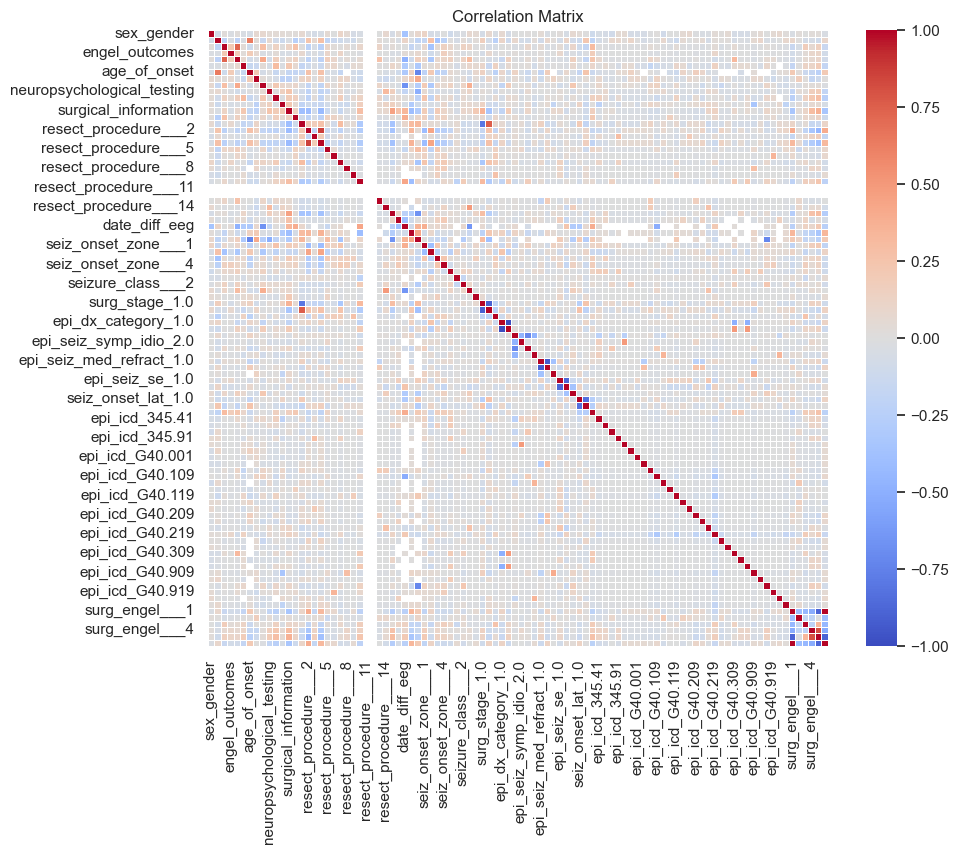

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

engel = wide_df[['surg_engel___1', 'surg_engel___2', 'surg_engel___3', 'surg_engel___4', 'surg_engel']]
engel = engel.rename(columns={'surg_engel': 'surg_engel_multi'})
y2 = y==0
engel = pd.concat([engel, y2], axis=1)

# Calculate the correlation matrix
correlation_matrix = pd.concat([X.drop("epi_dx", axis=1), engel], axis=1).corr()

# Create a heatmap using seaborn
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

### Check for high correlation variables

In [7]:
# Set a threshold for high correlation (e.g., 0.8 for 80%)
threshold = 0.8

# Find pairs of variables with a very high correlation
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

# Print the pairs of variables with a very high correlation
print(f"Pairs of variables with correlation above {threshold}:")
for pair in high_correlation_pairs:
    print(pair)
    
del correlation_matrix, threshold, high_correlation_pairs, pair, i, j

Pairs of variables with correlation above 0.8:
('resect_procedure___1', 'surg_stage_1.0')
('resect_procedure___2', 'resect_procedure___4')
('surg_stage_1.0', 'surg_stage_2.0')
('epi_dx_category_1.0', 'epi_dx_category_2.0')
('epi_seiz_med_refract_1.0', 'epi_seiz_med_refract_2.0')
('epi_seiz_se_1.0', 'epi_seiz_se_2.0')
('seiz_onset_lat_1.0', 'seiz_onset_lat_2.0')
('surg_engel___1', 'surg_engel_multi')
('surg_engel___1', 'surg_engel')
('surg_engel___4', 'surg_engel_multi')
('surg_engel_multi', 'surg_engel')


### Check that the Binary Engel outcome worked

In [8]:
# Create a boolean mask for rows with different values
mask = engel["surg_engel"] != engel["surg_engel___1"]

# Filter the DataFrame based on the mask
rows_with_different_values = engel[mask]

# Display rows with different values
print("\nRows with different values:")
print(rows_with_different_values)

del mask, rows_with_different_values


Rows with different values:
Empty DataFrame
Columns: [surg_engel___1, surg_engel___2, surg_engel___3, surg_engel___4, surg_engel_multi, surg_engel]
Index: []


## To transform from a multiclass prediction to a single class prediction

In [9]:
# Trying to predict Engel class I
y = y==0

## Split data into train/test

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## Term frequency analysis

Important ngrams are selected based on their Shannon Entropy.

In [11]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import entropy

# Create and fit a CountVectorizer
count_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3))  # binary=True will set all non-zero counts to 1
count_vectorizer.fit(X_train["epi_dx"])

# Transform the training and test data
X_train_count = count_vectorizer.transform(X_train["epi_dx"])
X_test_count = count_vectorizer.transform(X_test["epi_dx"])

# Convert to DataFrame
X_train_count_df = pd.DataFrame(X_train_count.toarray(), columns=count_vectorizer.get_feature_names_out())
X_test_count_df = pd.DataFrame(X_test_count.toarray(), columns=count_vectorizer.get_feature_names_out())

# Calculate probabilities for the presence (1) and absence (0) of each term
probabilities = X_train_count_df.apply(lambda x: [np.mean(x), 1 - np.mean(x)], result_type='expand')

# Calculate Shannon entropy using scipy.stats.entropy
entropies_scipy = probabilities.apply(lambda x: entropy(x, base=2), axis=0)

# Sort features by their entropy
entropies_sorted_scipy = entropies_scipy.sort_values()

del count_vectorizer

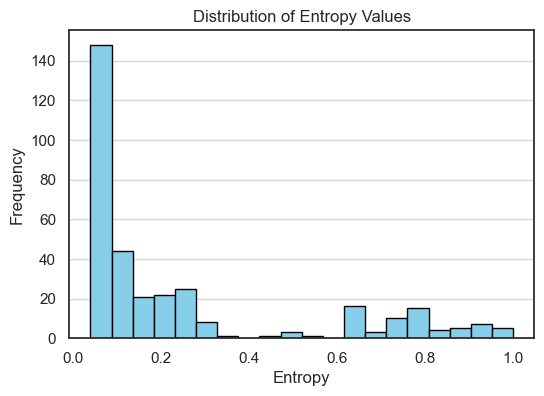

In [12]:
import matplotlib.pyplot as plt

# Plot the distribution of entropy values
plt.figure(figsize=(6, 4))
plt.hist(entropies_sorted_scipy, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Entropy Values')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [13]:
# Filter Entropies to get a range of useful values
filtered_entropies_sorted = entropies_sorted_scipy[(entropies_sorted_scipy>0.3) & (entropies_sorted_scipy<0.7)]

# Filtered columns based on entropy thresholds
filtered_columns = filtered_entropies_sorted.index.tolist()

# Select columns from the DataFrames based on filtered features by entropy
X_train_filtered = X_train_count_df[filtered_columns]
X_test_filtered = X_test_count_df[filtered_columns]

# Remove the 'epi_dx' column from X_train and X_test
X_train = X_train.drop('epi_dx', axis=1)
X_test = X_test.drop('epi_dx', axis=1)

# Filter out the features that have the same name as columns in X_train and X_test to avoid duplication
common_columns = set(X_train.columns) & set(X_train_filtered.columns)
X_train_filtered_unique = X_train_filtered.drop(columns=common_columns)
X_test_filtered_unique = X_test_filtered.drop(columns=common_columns)

# Concatenate the filtered features with the modified X_train and X_test
X_train = pd.concat([X_train.reset_index(drop=True), X_train_filtered_unique.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_filtered_unique.reset_index(drop=True)], axis=1)

del common_columns, X_train_filtered_unique, X_test_filtered_unique, X_train_filtered, X_test_filtered, filtered_columns, filtered_entropies_sorted

## 10-fold nested cross-validation

This step is done here in order to avoid data leakage of the scaling and imputing into the validation set used in the CV

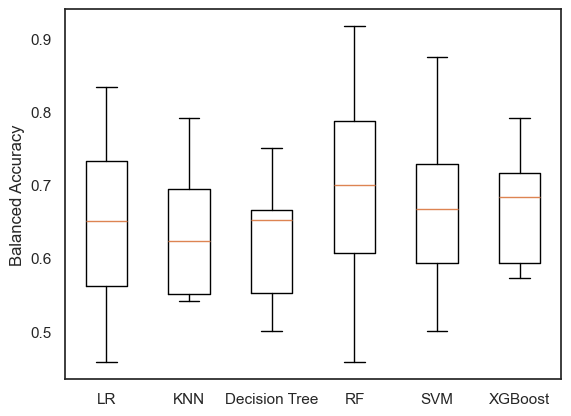

In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline

# List of continuous variables
numeric_var = ["age", "age_of_onset", "eo_days_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month",
               "date_diff_eeg", "date_diff_neuropsychological_testing", "date_diff_mri"] # , "prev_aeds_num"


column_names = numeric_var + list(set(X_train.columns) - set(numeric_var))

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Define models
models = {
    "LR": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(max_iter=2000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

results = []

# Loop through models
for model_name, model in models.items():
    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Create a stratified k-fold cross-validator
    kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

    # Cross-validate using the pipeline
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='balanced_accuracy', n_jobs=-1)

    # Append cross-validation results to the results list
    results.append(cv_results)

# Plot the results
plt.boxplot(results, labels=models.keys())
plt.ylabel('Balanced Accuracy')
plt.show()

### Nested CV with hyperparameter tuning

In the following, I plotted the AUC score for a few models after preprocessing, feature selection and hyperparameter tuning.

The inner CV is for hyperparameter tuning while the outer CV is for scoring.

c:\Users\amaur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1000 fits failed out of a total of 6250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\amaur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\amaur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\amaur\A

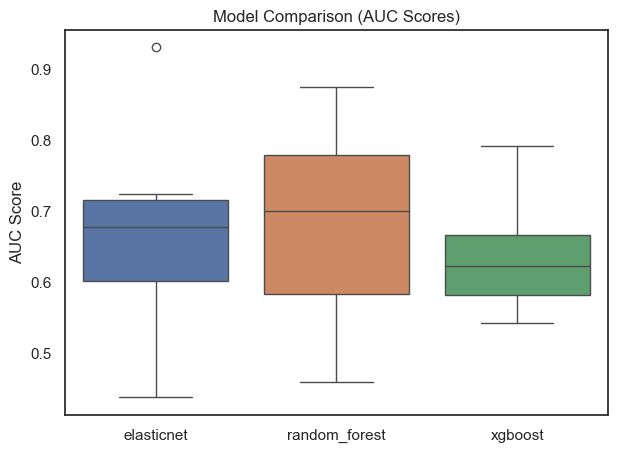

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

X_CV = X_train.copy()
y_CV = y_train.copy()

# Define model pipelines with named steps and feature selection
model_pipelines = {
    'elasticnet': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectFromModel(ElasticNet(random_state=42))),
        ('model', ElasticNet())
    ]),
    'random_forest': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
        ('model', RandomForestClassifier())
    ]),
    'xgboost': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectFromModel(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))),
        ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ])
    #'svm': Pipeline([
    #    ('preprocessor', preprocessor),
    #    ('feature_selection', SelectFromModel(SVC(kernel="linear", random_state=42))),
    #    ('model', SVC())
    #])
}

# Define hyperparameter grids for each model
models_and_parameters = {
    'elasticnet': {'feature_selection__estimator__alpha': np.linspace(0, 1, 5), 
                   'feature_selection__estimator__l1_ratio': np.linspace(0, 1, 5),
                   'model__alpha': np.linspace(0, 1, 5), 
                   'model__l1_ratio': np.linspace(0, 1, 5)},
    'random_forest': {'feature_selection__estimator__n_estimators': np.linspace(5, 120, 5, dtype=int), 
                      'model__n_estimators': np.linspace(5, 100, 5, dtype=int), 
                      'model__max_depth': np.linspace(2, 10, 5, dtype=int)},
    'xgboost': {'feature_selection__estimator__n_estimators': np.linspace(5, 120, 5, dtype=int), 
                'model__n_estimators': np.linspace(5, 120, 5, dtype=int), 
                'model__learning_rate': np.logspace(-3, -1, 3)}
    #'svm': {'feature_selection__estimator__C': np.logspace(-3, 2, 6),
    #        'model__C': np.logspace(-3, 2, 6),
    #        'model__kernel': ['linear', 'rbf', 'poly'],
    #        'model__gamma': ['scale', 'auto']}
}

# Perform nested cross-validation and store selected features
outer_cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
inner_cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
results = {}
selected_features = {}
best_params = {}

for model_name, pipeline in model_pipelines.items():
    param_grid = models_and_parameters[model_name]
    auc_scores = []
    features_selected = []
    params = []

    for train_idx, test_idx in outer_cv.split(X_CV, y_CV):
        X_train_fold, X_test_fold = X_CV.iloc[train_idx], X_CV.iloc[test_idx]
        y_train_fold, y_test_fold = y_CV.iloc[train_idx], y_CV.iloc[test_idx]

        # Inner CV for hyperparameter tuning
        grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train_fold, y_train_fold)

        # Best model and parameters
        best_model = grid_search.best_estimator_
        params.append(grid_search.best_params_)

        # Evaluate on test set
        y_pred = best_model.predict(X_test_fold)
        auc_score = roc_auc_score(y_test_fold, y_pred)
        auc_scores.append(auc_score)

    results[model_name] = auc_scores
    best_params[model_name] = params

# Convert results to a DataFrame for easier plotting
all_scores = pd.DataFrame(results)

# Plot AUC scores
plt.figure(figsize=(7, 5))
sns.boxplot(data=all_scores)
plt.title('Model Comparison (AUC Scores)')
plt.ylabel('AUC Score')
plt.show()

# Logistic Regression model

In [15]:
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

# List of continuous variables
numeric_var = ["age", "age_of_onset", "eo_days_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month", "date_diff_eeg",
               "date_diff_neuropsychological_testing", "date_diff_mri"] # , "prev_aeds_num"

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_train_processed = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())

X_test_processed = preprocessor.transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Initialize LogisticRegressionCV
log_reg_cv = LogisticRegressionCV(l1_ratios=np.linspace(0, 1, 10),
                                  penalty='elasticnet',
                                  solver='saga',
                                  cv=cv,
                                  scoring="roc_auc",
                                  random_state=0,
                                  max_iter=10000,
                                  n_jobs=-1)

# Fit the model
log_reg_cv.fit(X_train_processed, y_train)

# Predict probabilities on the training set
y_train_pred_proba = log_reg_cv.predict_proba(X_train_processed)[:, 1]

# Compute AUC score on the training set
train_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f"Training AUC: {train_auc}")

# Coefficients plot
feature_names = X_train_processed.columns
coefficients = log_reg_cv.coef_.flatten()

Training AUC: 0.7954482758620689


# Elasticnet model

In [16]:
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold


# Define model pipelines with named steps and feature selection
pipeline = Pipeline([
        ('preprocessor', preprocessor),
        #('feature_selection', SelectFromModel(ElasticNet(random_state=42))),
        ('model', ElasticNet(max_iter=10000))
])

param_grid = {#'feature_selection__estimator__alpha': np.linspace(0, 1, 5),
              #'feature_selection__estimator__l1_ratio': np.linspace(0, 1, 5),
              'model__alpha': np.linspace(0, 1, 5),
              'model__l1_ratio': np.linspace(0, 1, 5)}

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Inner CV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_


# Predict probabilities on the training set
y_train_pred = best_model.predict(X_train)

# Compute AUC score on the training set
train_auc = roc_auc_score(y_train, y_train_pred)
print(f"Training AUC: {train_auc}")

# Evaluate on test set
y_pred = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, y_pred)
print(f"Test AUC: {test_auc}")

c:\Users\amaur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\amaur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\amaur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


Training AUC: 0.9363448275862069
Test AUC: 0.6842672413793104


c:\Users\amaur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.320e+01, tolerance: 6.017e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [17]:
from sklearn.metrics import classification_report

y_test_pred = log_reg_cv.predict(X_test_processed)

print(classification_report(y_test_pred, y_test))

              precision    recall  f1-score   support

       False       0.38      0.79      0.51        14
        True       0.91      0.62      0.73        47

    accuracy                           0.66        61
   macro avg       0.64      0.70      0.62        61
weighted avg       0.79      0.66      0.68        61



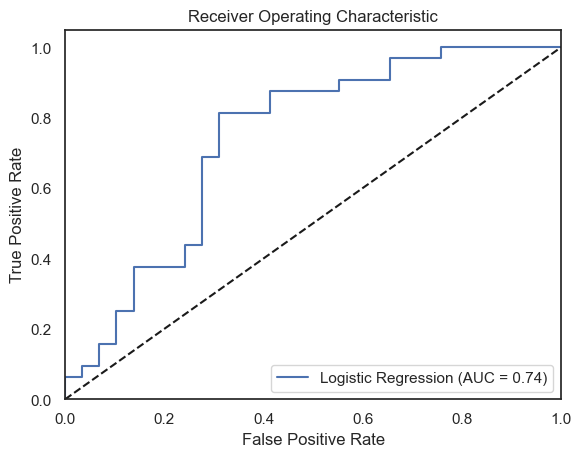

In [18]:
# Predict probabilities on the testing set
y_test_pred_proba = log_reg_cv.predict_proba(X_test_processed)[:, 1]

# Compute AUC score on the testing set
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Random Forest

In [19]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV


param_grid = {'n_estimators': np.linspace(5, 115, 15, dtype=int),
               'max_depth': np.linspace(2, 10, 10, dtype=int)}

clf = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

clf_cv = GridSearchCV(clf, param_grid,
                      cv=10,
                      scoring="roc_auc",
                      n_jobs=-1)

# Fit the model
clf_cv.fit(X_train_processed, y_train)

# Predict probabilities on the training set
y_train_pred_proba = clf_cv.predict_proba(X_train_processed)[:, 1]

# Compute AUC score on the training set
train_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f"Training AUC: {train_auc}")

Training AUC: 0.9951034482758621


In [20]:
from sklearn.metrics import classification_report

y_test_pred = clf_cv.predict(X_test_processed)

print(classification_report(y_test_pred, y_test))

              precision    recall  f1-score   support

       False       0.55      0.73      0.63        22
        True       0.81      0.67      0.73        39

    accuracy                           0.69        61
   macro avg       0.68      0.70      0.68        61
weighted avg       0.72      0.69      0.69        61



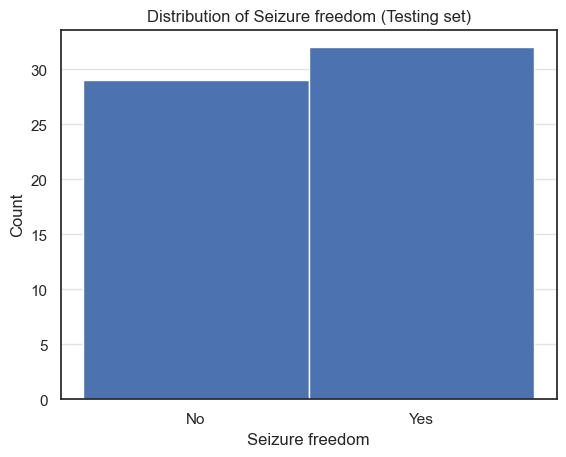

In [21]:
# Create a histogram of the 'surg_engel' variable
plt.hist(y_test+1, bins=[1, 2, 3])  # Specify the bin edges

# Customize x-axis ticks and labels
bin_centers = [1.5, 2.5]
plt.xticks(bin_centers, ['No', 'Yes'])

# Add labels and title
plt.xlabel('Seizure freedom')
plt.ylabel('Count')
plt.title('Distribution of Seizure freedom (Testing set)')

# Add grid for better readability
plt.grid(axis='y', alpha=0.55)

# Show the plot
plt.show()

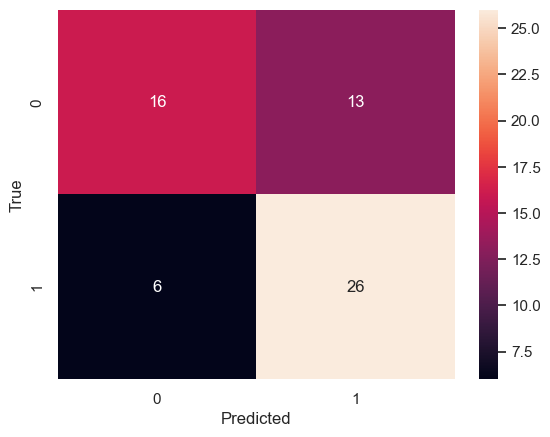

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
# Predict probabilities on the testing set
y_test_pred_proba = clf_cv.predict_proba(X_test_processed)[:, 1]

# Compute AUC score on the testing set
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Print AUC score on the testing set
print(f"Testing AUC: {test_auc}")

Testing AUC: 0.7510775862068966


In [24]:
# Update column names by removing "remainder__" and "pipeline__" prefixes
X_test_processed.columns = [col.replace("remainder__", "").replace("pipeline__", "") for col in X_test_processed.columns]

## SHAP Values

We use SHAP values to determine the importance of the different variables and the direction of their effects.

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


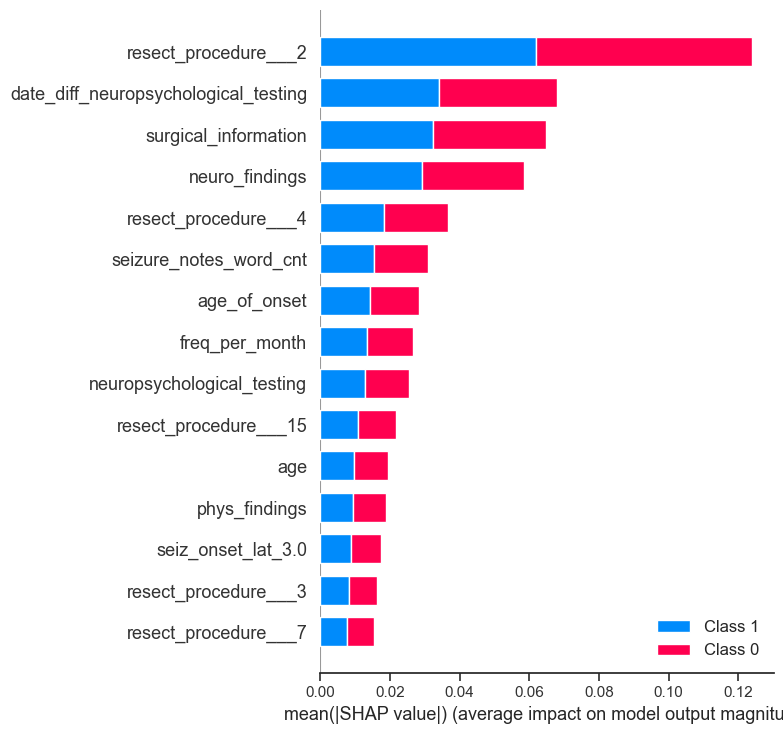

In [25]:
import shap

explainer = shap.TreeExplainer(clf_cv.best_estimator_)
shap_values = explainer.shap_values(X_test_processed)

shap.summary_plot(shap_values, X_test_processed, max_display=15)

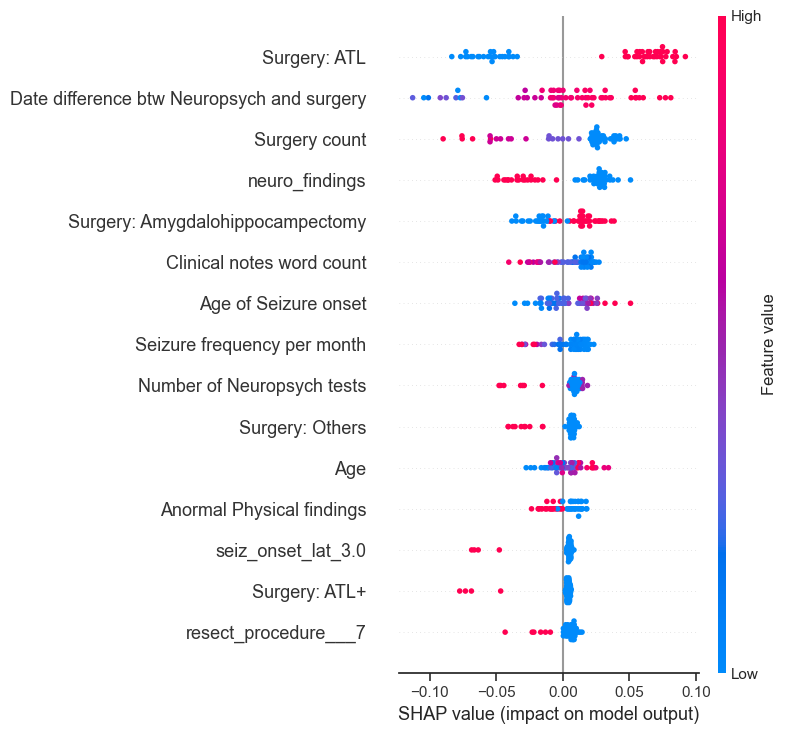

In [26]:
import shap

# Update column names by removing "remainder__" and "pipeline__" prefixes
X_test_processed.columns = [col.replace("remainder__", "").replace("pipeline__", "") for col in X_test_processed.columns]

change_column_name = {"resect_procedure___2":"Surgery: ATL",
                      "resect_procedure___3":"Surgery: ATL+",
                      "resect_procedure___4":"Surgery: Amygdalohippocampectomy",
                      "resect_procedure___5":"Surgery: Lesionectomy",
                      "resect_procedure___15":"Surgery: Others",
                      "surgical_information":"Surgery count",
                      "age_of_onset":"Age of Seizure onset",
                      "freq_per_month":"Seizure frequency per month",
                      "age":"Age",
                      "neuropsychological_testing":"Number of Neuropsych tests",
                      "seizure_notes_word_cnt":"Clinical notes word count",
                      "eo_days_postsurg":"Number of days post-surgery",
                      "phys_findings":"Anormal Physical findings",
                      "date_diff_neuropsychological_testing":"Date difference btw Neuropsych and surgery"
                      }

X_test_processed_name = X_test_processed.rename(columns=change_column_name)

explainer = shap.TreeExplainer(clf_cv.best_estimator_)
shap_values = explainer.shap_values(X_test_processed)

shap.summary_plot(shap_values[1], X_test_processed_name, max_display=15)

## Reduce Number of Input variables

Here, we use the top features based on their SHAP values to train a new model.

In [27]:
import pandas as pd
import numpy as np

# 1. Calculate the mean absolute SHAP values for each feature
shap_sum = np.abs(shap_values[1]).mean(axis=0)
importance_df = pd.DataFrame([X_test_processed.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['Feature Name', 'SHAP Importance']
importance_df['SHAP Importance'] = importance_df['SHAP Importance'].astype(float)

# 2. Sort the dataframe by SHAP Importance in descending order to get the top features
importance_df = importance_df.sort_values('SHAP Importance', ascending=False).reset_index(drop=True)

# 3. Select the top 15 features
top_features = importance_df.head(20)['Feature Name'].values
#top_features = np.array([feature.replace("remainder__", "").replace("pipeline__", "") for feature in top_features])

# Now, you can select only these top features from your dataset
X_train_selected = X_train[top_features]
X_test_selected = X_test_processed[top_features]

In [28]:
import numpy as np
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

# List of continuous variables
numeric_var = ["age", "age_of_onset", "eo_days_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month",
               "date_diff_eeg", "date_diff_neuropsychological_testing", "date_diff_mri"] # , "prev_aeds_num"

# Filter the list to keep only those variables that are columns in X_train_selected
numeric_var_selected = [var for var in numeric_var if var in X_train_selected.columns]

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var_selected),
    remainder=categorical_pipe
)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train_selected)
X_train_processed = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())

X_test_processed = preprocessor.transform(X_test_selected)
X_test_processed = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())

param_grid = {'n_estimators': np.linspace(5, 115, 15, dtype=int),
               'max_depth': np.linspace(2, 10, 10, dtype=int)}

clf = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

clf_cv = GridSearchCV(clf, param_grid,
                      cv=10,
                      scoring="roc_auc",
                      n_jobs=-1)

# Fit the model
clf_cv.fit(X_train_processed, y_train)

# Predict probabilities on the training set
y_train_pred_proba = clf_cv.predict_proba(X_train_processed)[:, 1]

# Compute AUC score on the training set
train_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f"Training AUC: {train_auc}")

Training AUC: 0.9177931034482759


In [29]:
# Predict probabilities on the testing set
y_test_pred_proba = clf_cv.predict_proba(X_test_processed)[:, 1]

# Compute AUC score on the testing set
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Print AUC score on the testing set
print(f"Testing AUC: {test_auc}")

Testing AUC: 0.7586206896551724


In [30]:
def create_surg_group(nbr_surg):
    if nbr_surg == 1:
        return "Group 1"
    elif nbr_surg == 2:
        return "Group 2"
    else:
        return "Group 3"
    
def convert_columns_to_boolean(df, numeric_vars):
    for col in df.columns:
        if col not in numeric_vars:
            df[col] = df[col].astype(bool)
    return df

In [31]:
import pandas as pd
from statsmodels.regression.mixed_linear_model import MixedLM

# List of continuous and non-continuous variables
numeric_var = ["age", "age_of_onset", "eo_yrs_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month"]  # , "prev_aeds_num"

# Variables in X_CV but not in numeric_var are treated as categorical
categorical_var = [col for col in X_train.columns if col not in numeric_var and col != 'y']


# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'))
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_train_processed = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())

X_test_processed = preprocessor.fit_transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())

# Clean column names by removing 'pipeline__' and 'remainder__'
X_train_processed.columns = [col.replace('pipeline__', '').replace('remainder__', '') for col in X_train_processed.columns]
X_test_processed.columns = [col.replace('pipeline__', '').replace('remainder__', '') for col in X_test_processed.columns]

# Convert non-numeric columns to boolean in both X_train and X_test
X_train = convert_columns_to_boolean(X_train_processed, numeric_var)
X_test = convert_columns_to_boolean(X_test_processed, numeric_var)


X_train_processed["surgical_group"] = X_train_processed["surgical_information"].apply(create_surg_group).astype("category")

# Ensure your DataFrame (X_CV) includes the target variable y_CV
X_train_processed['surg_engel'] = y_train.copy()

# Construct the formula
#formula_parts = [f"C(Q('{var}'))" for var in categorical_var]
#formula_parts = [f"Q('{var}')" for var in numeric_var]
#formula = 'y ~ ' + ' + '.join(formula_parts)

formula = """surg_engel ~ age + age_of_onset + eo_yrs_postsurg + eo_year_surg + freq_per_month + 
C(sex_gender) + C(resect_procedure___2) + C(neuro_findings) + 
C(seiz_onset_zone___1) + eeg + 
neuropsychological_testing + phys_findings + C(seizure_class___2) + 
mri""".replace("\n", "")

# Define the model
groups_var = 'surgical_group'  # Random effects variable

model = MixedLM.from_formula(formula, groups=groups_var, data=X_train_processed)
result = model.fit()
print(result.summary())

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
from sklearn.metrics import roc_auc_score

# Predict probabilities for the positive class
y_pred_prob = result.predict(X_test_processed)  # Make sure this returns probabilities

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)

print(f'AUC: {auc}')

## Null accuracy

In [32]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Create a DummyClassifier that always predicts the most frequent class
dummy_classifier = DummyClassifier(strategy='most_frequent')

# Fit the DummyClassifier on the training data
dummy_classifier.fit(X_train, y_train)

# Make predictions on the training data
y_pred_dummy = dummy_classifier.predict(X_train)

# Calculate null accuracy
null_accuracy = accuracy_score(y_train, y_pred_dummy)

print(f"Null Accuracy: {null_accuracy:.2f}")

Null Accuracy: 0.52


## Print system information

In [33]:
import session_info

session_info.show()